# Variational Autoencoder

Go from input dim to a small tensor of gaussians parameterized by mu and sigma and then build out to the larger output dim (equal to input dim).

Later, sample from the gaussian distribution to interpolate within the distribution learn by the VAE.

---

Example: Train on emojis and then sample novel emojis.

# MNIST

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
# fmnist_data_check.py
import jax
import jax.numpy as jnp
import numpy as np
from datasets import load_dataset
from einops import rearrange
import optax
from functools import partial
from dataclasses import dataclass
import equinox as eqx
from jaxtyping import Float, Array, jaxtyped
from typing import Tuple, Iterator
from beartype import beartype

print("JAX devices:", jax.devices())
print("Default device:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default device: cpu


In [3]:
def to_float01(example):
    # convert PIL image -> float32 [0,1], add channel dim (1, 28, 28)
    arr = np.array(example["image"], dtype=np.float32) / 255.0
    arr = rearrange(arr, "h w -> h w 1")
    example["x"] = arr
    return example

In [4]:
# 1) load HF dataset
ds = load_dataset("fashion_mnist")

In [5]:
# 2) map -> float32, add channel dim
ds = ds.map(to_float01, remove_columns=["image"])

In [6]:
# 3) train/test numpy arrays
x_train = np.stack([ex["x"] for ex in ds["train"]], axis=0)  # (60000,1,28,28)
y_train = np.array(ds["train"]["label"])
x_test  = np.stack([ex["x"] for ex in ds["test"]], axis=0)   # (10000,1,28,28)

print("x_train:", x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print("x_test :", x_test.shape,  x_test.dtype)

x_train: (60000, 28, 28, 1) float64 0.0 1.0
x_test : (10000, 28, 28, 1) float64


In [47]:
def data_loader(x: np.ndarray, batch_size: int, key: jax.Array, shuffle: bool=True) -> Iterator[jax.Array]:
    """Yields jnp.float32 batches shaped (B, 28, 28, 1) in [0,1]."""
    B, H, W, C = x.shape
    if shuffle:
        perm = np.array(jax.random.permutation(key, B))
    else:
        perm = np.arange(B)
    for i in range(0, B, batch_size):
        batch = x[perm[i:i+batch_size]]
        yield jnp.asarray(batch)

In [56]:
# quick smoke test
main_key, loader_key = jax.random.split(jax.random.PRNGKey(0))
batches = data_loader(x_train, batch_size=256, key=loader_key)

count = 0
for batch in batches:
    count += 1
    xb = batch
    # print("one batch:", xb.shape, xb.dtype, xb.device)

print(count)

235


In [20]:
def flatten_images(x: Float[Array, "B H W C"]) -> Float[Array, "B (H W C)"]:
    b, h, w, c = x.shape
    return x.reshape(b, h*w*c)

def unflatten_images(x: Float[Array, "B (H W C)"]) -> Float[Array, "B H W C"]:
    b, hwc = x.shape
    return x.reshape(b, 28, 28, 1)

In [21]:
x = jnp.zeros((100, 28, 28, 1))
y = flatten_images(x)
y.shape

(100, 784)

# VAE

In [22]:
class VAE(eqx.Module):
    encoder: eqx.nn.MLP
    mu_head: eqx.nn.Linear
    logvar_head: eqx.nn.Linear
    decoder: eqx.nn.MLP
    latent_dim: int

    def __init__(self, key: jax.Array, input_dim: int = 28*28, latent_dim: int = 16, width: int = 256, depth: int = 2):
        # input_dim -> width -> width (depth times) -> latent_dim -> 
        #  -> width -> width (depth times) -> input_dim
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = eqx.nn.MLP(in_size=input_dim, out_size=width, width_size=width, depth=depth, activation=jax.nn.gelu, key=k1)
        self.mu_head = eqx.nn.Linear(width, latent_dim, use_bias=True, key=k2)
        self.logvar_head = eqx.nn.Linear(width, latent_dim, use_bias=True, key=k3)
        self.decoder = eqx.nn.MLP(in_size=latent_dim, out_size=input_dim, width_size=width, depth=depth, activation=jax.nn.gelu, key=k4)
        self.latent_dim = latent_dim

    def encode(self, x: Float[Array, "B (H W C)"]) -> Tuple[
        Float[Array, "B latent"], Float[Array, "B latent"]]:
        # B (H W C) -> (B Ldim, B Ldim)
        h = jax.vmap(self.encoder)(x)
        mu = jax.vmap(self.mu_head)(h)
        logvar = jax.vmap(self.logvar_head)(h)
        return mu, logvar

    def sample_z(self, mu: Array, logvar: Array, key: Array) -> Array:
        # reparameterization trick: z = mu + std * eps
        eps = jax.random.normal(key, shape=mu.shape, dtype=mu.dtype)
        std = jnp.exp(0.5 * logvar)
        return mu + std * eps

    def decode(self, z: Float[Array, "B latent"]) -> Float[Array, "B (H W C)"]:
        return jax.vmap(self.decoder)(z)

    def __call__(self, x: Float[Array, "B (H W C)"], key: Array) -> Tuple[Float[Array, "B (W H C)"], Tuple[Array, Array, Array]]:
        mu, logvar = self.encode(x)
        key, key_z = jax.random.split(key)
        z = self.sample_z(mu, logvar, key_z)
        logits = self.decode(z)
        return logits, (mu, logvar, z)

In [23]:
SEED = 42
key = jax.random.PRNGKey(SEED)
model = VAE(key, latent_dim=8, width=128, depth=2)

In [24]:
import jax
import equinox as eqx

def count_params(tree) -> int:
    leaves = jax.tree_util.tree_leaves(eqx.filter(tree, eqx.is_inexact_array))
    return sum(int(x.size) for x in leaves)

def print_param_summary(model):
    parts = {
        "encoder": model.encoder,
        "mu_head": model.mu_head,
        "logvar_head": model.logvar_head,
        "decoder": model.decoder,
    }
    for name, part in parts.items():
        print(f"{name:12s}: {count_params(part):8d} params")
    print(f"{'TOTAL':12s}: {count_params(model):8d} params")

print_param_summary(model)

encoder     :   133504 params
mu_head     :     1032 params
logvar_head :     1032 params
decoder     :   118800 params
TOTAL       :   254368 params


# Loss

In [25]:
def bce_with_logits(logits: Array, targets: Array) -> Array:
    # per-element BCE: max(l,0) - l*x + lop1p(exp(-|l|))
    l = logits
    x = targets
    return jnp.maximum(l, 0.0) - l * x + jnp.log1p(jnp.exp(-jnp.abs(l)))

In [26]:
def kl_standard_normal(mu: Array, logvar: Array) -> Array:
    # KL[q(z|x) || p(z)] for diagonal Gaussians where p(z)=N(0,I), q has (mu, logvar)
    return 0.5 * (jnp.exp(logvar) + jnp.square(mu) - 1.0 - logvar)

In [27]:
def elbo_loss(model, x: Float[Array, "B H W C"], key: Array, beta: float = 1.0) -> Tuple[Float[Array, ""], dict[str, Float[Array, ""]]]:
    # Beta VAE
    x_flat = flatten_images(x) # B (H W C)
    logits, (mu, logvar, z) = model(x_flat, key)

    # ConvVAE
    # logits, (mu, logvar, z) = model(x, key)
    # x_flat = flatten_images(x) # B (H W C)

    # recon NLL per example: sum over pixels
    recon_per_pix = bce_with_logits(logits, x_flat) # B (H W C)
    recon = jnp.sum(recon_per_pix, axis=-1) # B

    # KL per example: sum over latent dims
    kl = jnp.sum(kl_standard_normal(mu, logvar), axis=-1) # B

    # loss = mean over batch
    loss = jnp.mean(recon + beta * kl)

    metrics = {
        "recon": jnp.mean(recon),
        "kl": jnp.mean(kl),
        "loss": loss
    }

    return loss, metrics

In [28]:
B = 64
xb = jnp.asarray(x_train[:B])
print(xb.shape)

main_key = jax.random.PRNGKey(42)
main_key, step_key = jax.random.split(main_key)

loss0, metrics0 = elbo_loss(model, xb, step_key, beta=1.0)
print({k: float(v) for k, v in metrics0.items()})

(64, 28, 28, 1)
{'recon': 545.1463623046875, 'kl': 0.01338273473083973, 'loss': 545.1597900390625}


# Training Loop

In [29]:
@eqx.filter_jit
def train_step(model: VAE, opt_state, x: jax.Array, key: jax.Array, beta: float=1.0):
    (loss, metrics), grads = eqx.filter_value_and_grad(elbo_loss, has_aux=True)(model, x, key, beta)
    updates, opt_state = optimizer.update(grads, opt_state, params=eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, metrics

In [31]:
# Dry run
main_key = jax.random.PRNGKey(0)
main_key, perm_key, step_key = jax.random.split(main_key, 3)

xb = next(data_loader(x_train, batch_size=128, key=perm_key, shuffle=True))

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(1e-4)
)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

model, opt_state, m = train_step(model, opt_state, xb, step_key, beta=1.0)
print({k: float(v) for k, v in m.items()})

{'kl': 0.013246439397335052, 'loss': 545.0926513671875, 'recon': 545.0792846679688}


In [32]:
from tqdm import trange

def evaluate_epoch(model: VAE, x: np.ndarray, batch_size: int=512) -> dict:
    # no grad, just average the metrics
    losses, recons, kls = [], [], []
    key = jax.random.PRNGKey(123) # deterministic eval RNG
    for xb in data_loader(x, batch_size=batch_size, key=key, shuffle=False):
        key, sub = jax.random.split(key)
        _, metr = elbo_loss(model, xb, sub, beta=1.0)
        losses.append(float(metr["loss"]))
        recons.append(float(metr["recon"]))
        kls.append(float(metr["kl"]))
    return {"loss": np.mean(losses), "recon": np.mean(recons), "kl": np.mean(kls)}

In [66]:
# Training loop
def beta_schedule(step, warmup_steps=1000):
    beta = float(min(1.0, step / warmup_steps))
    # print(f"step={step}; beta={beta}")
    return beta

def train(
    model: VAE,
    x_train: np.ndarray,
    x_test: np.ndarray,
    key: Array,
    *,
    epochs: int = 20,
    batch_size: int = 256
):
    main_key = key
    
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(1e-3)
    )
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

    total_step = 0
    for epoch in trange(1, epochs + 1):
        main_key, perm_key = jax.random.split(main_key)
        loader = data_loader(x_train, batch_size, perm_key)

        running = {"loss": 0.0, "recon": 0.0, "kl": 0.0}
        step = 0

        for xb in loader:
            main_key, step_key = jax.random.split(main_key)
            print(xb.shape)
            model, opt_state, metr = train_step(model, opt_state, xb, step_key, beta=beta_schedule(total_step))
            step += 1
            total_step += 1

            running["loss"] += float(metr["loss"])
            running["recon"] += float(metr["recon"])
            running["kl"] += float(metr["kl"])

        for key in running:
            running[key] /= step

        eval_m = evaluate_epoch(model, x_test, batch_size=512)
        print(f"epoch {epoch:02d} | train loss {running['loss']:.1f} (recon {running['recon']:.1f}, kl {running['kl']:.2f}), "f"| test loss {eval_m['loss']:.1f} (recon {eval_m['recon']:.1f}, kl {eval_m['kl']:.2f})")
    return model

# Training

In [67]:
main_key, model_key, train_key = jax.random.split(main_key, 3)

# model = ConvVAE(key=model_key, latent_dim=16)
model = train(model, x_train, x_test, train_key)

  0%|                                                                                                                                                                                                          | 0/20 [00:00<?, ?it/s]

(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 

  5%|█████████▋                                                                                                                                                                                        | 1/20 [00:01<00:21,  1.15s/it]

epoch 01 | train loss 235.3 (recon 233.2, kl 17.70), | test loss 251.2 (recon 234.8, kl 16.41)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 10%|███████████████████▍                                                                                                                                                                              | 2/20 [00:02<00:20,  1.13s/it]

epoch 02 | train loss 238.6 (recon 233.3, kl 15.18), | test loss 249.6 (recon 235.4, kl 14.11)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 15%|█████████████████████████████                                                                                                                                                                     | 3/20 [00:03<00:19,  1.15s/it]

epoch 03 | train loss 241.9 (recon 234.0, kl 13.51), | test loss 248.7 (recon 235.9, kl 12.84)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 20%|██████████████████████████████████████▊                                                                                                                                                           | 4/20 [00:04<00:18,  1.14s/it]

epoch 04 | train loss 244.8 (recon 234.6, kl 12.40), | test loss 248.5 (recon 236.5, kl 11.94)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 25%|████████████████████████████████████████████████▌                                                                                                                                                 | 5/20 [00:05<00:17,  1.14s/it]

epoch 05 | train loss 246.6 (recon 235.0, kl 11.68), | test loss 248.4 (recon 236.8, kl 11.60)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 6/20 [00:06<00:15,  1.13s/it]

epoch 06 | train loss 246.6 (recon 235.0, kl 11.63), | test loss 248.3 (recon 236.7, kl 11.64)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                              | 7/20 [00:07<00:14,  1.12s/it]

epoch 07 | train loss 246.5 (recon 234.9, kl 11.63), | test loss 248.1 (recon 236.5, kl 11.54)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8/20 [00:09<00:13,  1.14s/it]

epoch 08 | train loss 246.3 (recon 234.7, kl 11.59), | test loss 248.0 (recon 236.3, kl 11.66)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9/20 [00:10<00:12,  1.13s/it]

epoch 09 | train loss 246.3 (recon 234.7, kl 11.61), | test loss 247.9 (recon 236.4, kl 11.49)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 10/20 [00:11<00:11,  1.12s/it]

epoch 10 | train loss 246.2 (recon 234.6, kl 11.59), | test loss 247.7 (recon 236.1, kl 11.66)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 11/20 [00:12<00:09,  1.11s/it]

epoch 11 | train loss 246.0 (recon 234.4, kl 11.60), | test loss 247.7 (recon 236.0, kl 11.66)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 12/20 [00:13<00:08,  1.10s/it]

epoch 12 | train loss 245.9 (recon 234.3, kl 11.59), | test loss 247.5 (recon 235.9, kl 11.67)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 13/20 [00:14<00:07,  1.11s/it]

epoch 13 | train loss 245.7 (recon 234.1, kl 11.60), | test loss 247.4 (recon 235.8, kl 11.66)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 14/20 [00:15<00:06,  1.11s/it]

epoch 14 | train loss 245.7 (recon 234.1, kl 11.60), | test loss 247.4 (recon 235.9, kl 11.54)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 15/20 [00:16<00:05,  1.11s/it]

epoch 15 | train loss 245.6 (recon 234.0, kl 11.59), | test loss 247.2 (recon 235.5, kl 11.64)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 16/20 [00:17<00:04,  1.13s/it]

epoch 16 | train loss 245.4 (recon 233.8, kl 11.60), | test loss 247.1 (recon 235.6, kl 11.55)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 17/20 [00:19<00:03,  1.12s/it]

epoch 17 | train loss 245.3 (recon 233.7, kl 11.61), | test loss 247.0 (recon 235.4, kl 11.65)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 18/20 [00:20<00:02,  1.12s/it]

epoch 18 | train loss 245.3 (recon 233.7, kl 11.63), | test loss 246.9 (recon 235.3, kl 11.54)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [00:21<00:01,  1.12s/it]

epoch 19 | train loss 245.1 (recon 233.5, kl 11.64), | test loss 246.8 (recon 235.2, kl 11.64)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

epoch 20 | train loss 245.0 (recon 233.4, kl 11.62), | test loss 246.7 (recon 235.1, kl 11.66)


# Inference

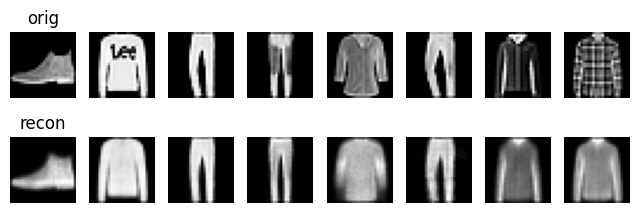

In [68]:
def reconstruct_from_mu(model: VAE, x_np: np.ndarray):
    xb = jnp.asarray(x_np)
    mu, logvar = model.encode(flatten_images(xb))          # no sampling
    logits = model.decode(mu)              # decode μ directly
    rec = jax.nn.sigmoid(logits).reshape((-1, 28, 28))
    orig = x_np[..., 0]
    return np.array(orig), np.array(rec)

def decode_logits_to_images(logits: jax.Array) -> np.ndarray:
    """logits (B,784) -> images (B,28,28) in [0,1] using sigmoid."""
    probs = jax.nn.sigmoid(logits)
    imgs = probs.reshape((-1, 28, 28))
    return np.array(imgs)

# visualize
N = 8
orig, rec = reconstruct_from_mu(model, x_test[:N])
import matplotlib.pyplot as plt
plt.figure(figsize=(N, 2.5))
for i in range(N):
    plt.subplot(2, N, i+1); plt.imshow(orig[i], cmap="gray"); plt.axis("off"); plt.title("orig" if i==0 else "")
    plt.subplot(2, N, N+i+1); plt.imshow(rec[i], cmap="gray"); plt.axis("off"); plt.title("recon" if i==0 else "")
plt.show()

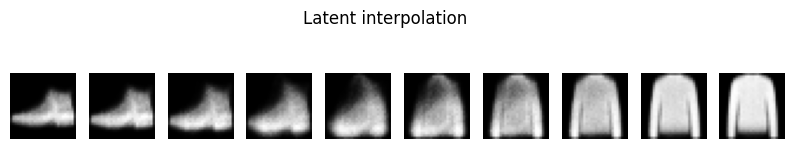

In [60]:
def encode_mu(model: VAE, x: np.ndarray) -> np.ndarray:
    mu, logvar = model.encode(x)
    return np.array(mu)

def decode_from_z(model: VAE, z: jax.Array) -> np.ndarray:
    logits = model.decode(z)
    return decode_logits_to_images(logits)

i, j = 0, 1  # two indices in test set
x_pair = jnp.asarray(x_test[[i, j]])
mu, _ = model.encode(flatten_images(x_pair))
z1, z2 = mu[0], mu[1]

k = 10
alphas = jnp.linspace(0, 1, k)
Z = jnp.stack([(1-a)*z1 + a*z2 for a in alphas], axis=0)
imgs = decode_from_z(model, Z)

plt.figure(figsize=(k, 2))
for t in range(k):
    plt.subplot(1, k, t+1); plt.imshow(imgs[t], cmap="gray"); plt.axis("off")
plt.suptitle("Latent interpolation")
plt.show()

In [ ]:
# class ConvVAE(eqx.Module):
#     enc1: eqx.nn.Conv2d
#     enc2: eqx.nn.Conv2d
#     enc_lin: eqx.nn.Linear
#     mu_head: eqx.nn.Linear
#     logvar_head: eqx.nn.Linear
#     dec_lin: eqx.nn.Linear
#     dec1: eqx.nn.ConvTranspose2d
#     dec2: eqx.nn.ConvTranspose2d
#     latent_dim: int

#     def __init__(self, key, latent_dim=16, width=256):
#         k1,k2,k3,k4,k5,k6, k7, k8 = jax.random.split(key, 8)
#         self.enc1 = eqx.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, key=k1)  # 28->14
#         self.enc2 = eqx.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, key=k2) # 14->7
#         self.enc_lin = eqx.nn.Linear(64*7*7, width, key=k3)
#         self.mu_head = eqx.nn.Linear(width, latent_dim, key=k4)
#         self.logvar_head = eqx.nn.Linear(width, latent_dim, key=k5)

#         self.dec_lin = eqx.nn.Linear(latent_dim, 64*7*7, key=k6)
#         self.dec1 = eqx.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, key=k7) # 7->14
#         self.dec2 = eqx.nn.ConvTranspose2d(32, 1,  kernel_size=4, stride=2, padding=1, key=k8) # 14->28
#         self.latent_dim = latent_dim

#     def encode(self, x):
#         h = jax.nn.gelu(self.enc1(x.transpose(0,3,1,2)))        # (B,1,28,28)->(B,32,14,14)
#         h = jax.nn.gelu(self.enc2(h))                            # ->(B,64,7,7)
#         h = h.reshape(h.shape[0], -1)
#         h = jax.nn.gelu(self.enc_lin(h))
#         mu, logvar = self.mu_head(h), self.logvar_head(h)
#         return mu, logvar

#     def sample_z(self, mu, logvar, key):
#         eps = jax.random.normal(key, mu.shape, dtype=mu.dtype)
#         std = jnp.exp(0.5 * logvar)
#         return mu + std * eps

#     def decode(self, z):
#         h = jax.nn.gelu(self.dec_lin(z))
#         h = h.reshape((-1, 64, 7, 7))
#         h = jax.nn.gelu(self.dec1(h))
#         logits = self.dec2(h)                                    # (B,1,28,28) logits
#         return logits.transpose(0,2,3,1).reshape((-1, 784))      # keep loss code unchanged

#     def __call__(self, x: Float[Array, "B (H W C)"], key: Array) -> Tuple[Float[Array, "B (W H C)"], Tuple[Array, Array, Array]]:
#         mu, logvar = self.encode(x)
#         key, key_z = jax.random.split(key)
#         z = self.sample_z(mu, logvar, key_z)
#         logits = self.decode(z)
#         return logits, (mu, logvar, z)